<a href="https://colab.research.google.com/github/EmaMule/Computer-Vision/blob/main/data/GroundSemantic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [99]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [100]:
from google.colab import drive
import os
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from transformers import Mask2FormerImageProcessor
from PIL import Image
import requests
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [101]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model Creation

In [102]:
processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic")

processor.do_resize = False
processor.do_rescale = True

print(model.config.id2label)

{0: 'Bird', 1: 'Ground Animal', 2: 'Curb', 3: 'Fence', 4: 'Guard Rail', 5: 'Barrier', 6: 'Wall', 7: 'Bike Lane', 8: 'Crosswalk - Plain', 9: 'Curb Cut', 10: 'Parking', 11: 'Pedestrian Area', 12: 'Rail Track', 13: 'Road', 14: 'Service Lane', 15: 'Sidewalk', 16: 'Bridge', 17: 'Building', 18: 'Tunnel', 19: 'Person', 20: 'Bicyclist', 21: 'Motorcyclist', 22: 'Other Rider', 23: 'Lane Marking - Crosswalk', 24: 'Lane Marking - General', 25: 'Mountain', 26: 'Sand', 27: 'Sky', 28: 'Snow', 29: 'Terrain', 30: 'Vegetation', 31: 'Water', 32: 'Banner', 33: 'Bench', 34: 'Bike Rack', 35: 'Billboard', 36: 'Catch Basin', 37: 'CCTV Camera', 38: 'Fire Hydrant', 39: 'Junction Box', 40: 'Mailbox', 41: 'Manhole', 42: 'Phone Booth', 43: 'Pothole', 44: 'Street Light', 45: 'Pole', 46: 'Traffic Sign Frame', 47: 'Utility Pole', 48: 'Traffic Light', 49: 'Traffic Sign (Back)', 50: 'Traffic Sign (Front)', 51: 'Trash Can', 52: 'Bicycle', 53: 'Boat', 54: 'Bus', 55: 'Car', 56: 'Caravan', 57: 'Motorcycle', 58: 'On Rails',

In [103]:
dir_path = "/content/drive/MyDrive/CV Project/CVUSA/streetview"
image_names = os.listdir(dir_path)

image_paths = []
for image_name in image_names:
    image_path = os.path.join(dir_path, image_name)
    image_paths.append(image_path)

image_paths[0]

'/content/drive/MyDrive/CV Project/CVUSA/streetview/0040212.jpg'

In [104]:
color_palette = [
    (196, 128, 128),  # Bird - Light Red
    (196, 128, 128),  # Ground Animal - Light Red
    (0, 0, 255),      # Curb - Blue
    (0, 128, 128),    # Fence - Teal
    (0, 196, 128),    # Guard Rail - Medium Green
    (32, 32, 128),    # Barrier -
    (32, 32, 128),    # Wall -
    (0, 0, 0),        # Bike Lane - Black
    (0, 0, 0),        # Crosswalk - Plain - Black
    (0, 0, 255),      # Curb Cut - Blue
    (0, 0, 0),        # Parking - Black
    (255, 255, 196),  # Pedestrian Area - Light Yellow
    (64, 64, 0),      # Rail Track - Olive
    (0, 0, 0),        # Road - Black
    (0, 0, 0),        # Service Lane - Black
    (255, 255, 0),    # Sidewalk - Yellow
    (0, 64, 0),       # Bridge - Dark Green
    (128, 128, 128),  # Building - Gray
    (0, 128, 0),      # Tunnel - Green
    (128, 0, 128),    # Person - Purple
    (128, 0, 128),    # Bicyclist - Purple
    (128, 0, 128),    # Motorcyclist - Purple
    (128, 0, 128),    # Other Rider - Purple
    (255, 255, 255),  # Lane Marking - Crosswalk - White
    (255, 255, 255),  # Lane Marking - General - White
    (128, 64, 0),     # Mountain - Brown
    (240, 230, 140),  # Sand - Khaki
    (135, 206, 235),  # Sky - Sky Blue
    (221, 242, 249),  # Snow - Light Blue
    (128, 128, 0),    # Terrain - Olive
    (0, 255, 0),      # Vegetation - Bright Green
    (0, 128, 255),    # Water - Medium Blue
    (128, 0, 0),      # Banner - Maroon
    (255, 192, 203),  # Bench - Pink
    (255, 192, 203),  # Bike Rack - Pink
    (128, 0, 0),      # Billboard - Maroon
    (196, 196, 0),    # Catch Basin - Yellow-Green
    (255, 192, 203),  # CCTV Camera - Pink
    (255, 192, 203),  # Fire Hydrant - Pink
    (255, 192, 203),  # Junction Box - Pink
    (255, 192, 203),  # Mailbox - Pink
    (196, 196, 0),    # Manhole - Yellow-Green
    (255, 192, 203),  # Phone Booth - Pink
    (0, 0, 0),        # Pothole - Black
    (255, 0, 255),    # Street Light - Fuchsia
    (255, 0, 255),    # Pole - Fuchsia
    (255, 0, 255),    # Traffic Sign Frame - Fuchsia
    (255, 0, 255),    # Utility Pole - Fuchsia
    (255, 0, 255),    # Traffic Light - Fuchsia
    (255, 0, 255),    # Traffic Sign (Back) - Fuchsia
    (255, 0, 255),    # Traffic Sign (Front) - Fuchsia
    (255, 192, 203),  # Trash Can - Pink
    (255, 128, 0),    # Bicycle - Orange
    (196, 64, 0),     # Boat - Dark Orange
    (255, 0, 0),      # Bus - Red
    (255, 0, 0),      # Car - Red
    (255, 0, 0),      # Caravan - Red
    (255, 128, 0),    # Motorcycle - Orange
    (196, 0, 64),     # On Rails - Dark Red
    (255, 0, 0),      # Other Vehicle - Red
    (255, 0, 0),      # Trailer - Red
    (255, 0, 0),      # Truck - Red
    (255, 0, 0),      # Wheeled Slow - Red
    (255, 0, 0),      # Car Mount - Red
    (255, 0, 0)       # Ego Vehicle - Red
]

# Example

/content/drive/MyDrive/CV Project/CVUSA/streetview/0000194.jpg


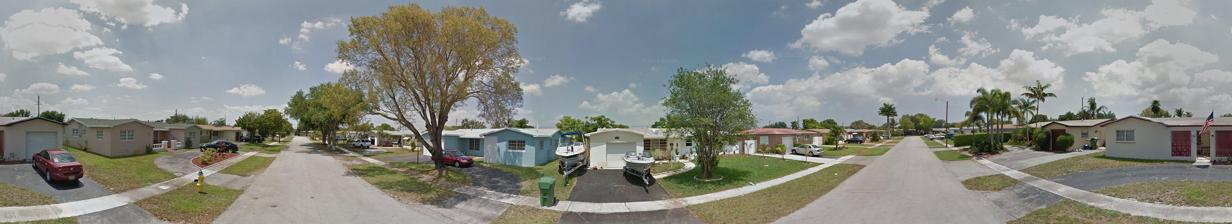

In [105]:
path = image_paths[0][0:51] + '0000194.jpg'
print(path)

image = Image.open(path)
image

In [106]:
inputs = processor(images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 224, 1232])
pixel_mask torch.Size([1, 224, 1232])


In [107]:
with torch.no_grad():
  outputs = model(**inputs)

class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])

print(outputs.class_queries_logits)

tensor([[[-3.8308, -6.0005,  4.0248,  ..., -4.3892, -3.9676,  7.9241],
         [-2.9289, -3.3505, -3.3595,  ..., -4.7732, -4.2627,  6.7671],
         [-1.1643, -1.7153, -1.8314,  ..., -4.3345, -4.2766,  6.2371],
         ...,
         [-2.4191, -0.5117, -3.0998,  ..., -5.0472, -5.3343,  7.2853],
         [-1.9484, -1.0281, -1.4756,  ..., -1.2167, -2.1579,  3.8751],
         [-5.2245, -6.1575, -2.1960,  ..., -6.9163, -6.7722,  7.8834]]])


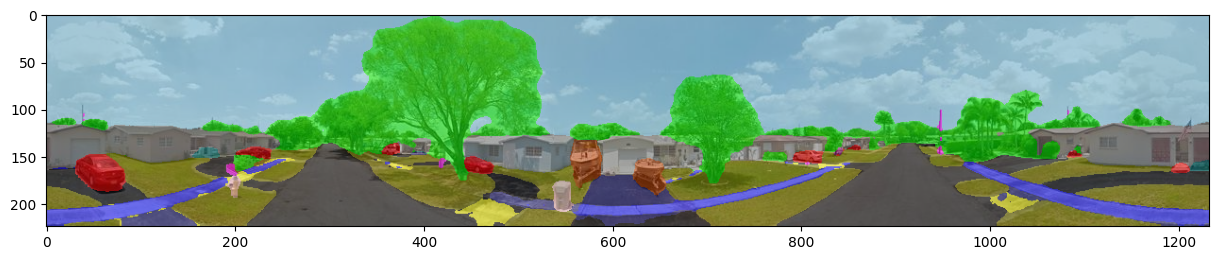

In [108]:
seg = predicted_semantic_map[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(color_palette)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color

color_seg = color_seg[..., ::1]

# Show image + mask
img = color_seg * 0.5 + np.array(image)*0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [109]:
def obtain_segmentation_map(model, img_path, sigma = 1.0):

    assert sigma <= 1 and sigma >= 0
    image = Image.open(img_path)
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
      outputs = model(**inputs)
    predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    seg = predicted_semantic_map
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(color_palette)
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    color_seg = color_seg[..., ::1]

    semantic_img = color_seg * sigma + np.array(image)*(1-sigma)
    semantic_img= semantic_img.astype(np.uint8)
    return semantic_img

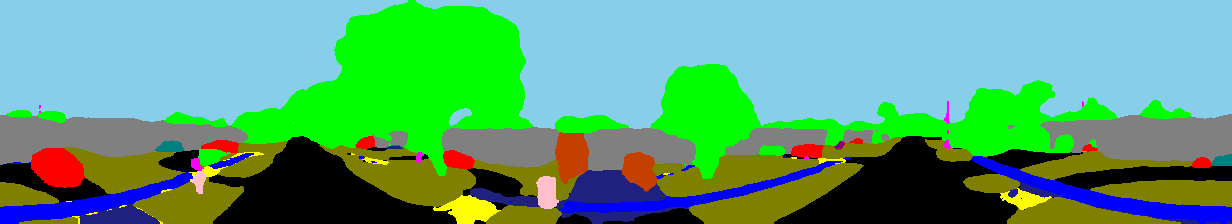

In [110]:
Image.fromarray(obtain_segmentation_map(model, path, sigma = 1.0))

# Dataset Creation

In [111]:
target_dir_path = "/content/drive/MyDrive/CV Project/CVUSA/streetview_segmentation2"

if not os.path.exists(target_dir_path):
    os.makedirs(target_dir_path)

segmentation_paths = []
for image_name in image_names:
    image_path = os.path.join(target_dir_path, image_name)
    segmentation_paths.append(image_path)

colored_depths = []
total_num = len(image_paths)
splits = [0, total_num//3, 2*total_num//3, total_num]

In [ ]:
# @title Ali

for i in tqdm(range(splits[0], splits[1])):
    if i % 200 == 0:
        gc.collect()
        torch.cuda.empty_cache()
    if not os.path.exists(segmentation_paths[i]):
        semantic_img = Image.fromarray(obtain_segmentation_map(model, image_paths[i], sigma = 1.0))
        semantic_img.save(segmentation_paths[i])

In [ ]:
# @title Emanuele

for i in tqdm(range(splits[1], splits[2])):
    if i % 200 == 0:
        gc.collect()
        torch.cuda.empty_cache()
    if not os.path.exists(segmentation_paths[i]):
        semantic_img = Image.fromarray(obtain_segmentation_map(model, image_paths[i], sigma = 1.0))
        semantic_img.save(segmentation_paths[i])

In [ ]:
# @title Matteo

for i in tqdm(range(splits[2], splits[3])):
    if i % 200 == 0:
        gc.collect()
        torch.cuda.empty_cache()
    if not os.path.exists(segmentation_paths[i]):
        semantic_img = Image.fromarray(obtain_segmentation_map(model, image_paths[i], sigma = 1.0))
        semantic_img.save(segmentation_paths[i])

  9%|▊         | 253/2954 [1:10:31<12:29:29, 16.65s/it]